In [1]:
!pip install scikit-learn umap-learn fuzzy-c-means pandas numpy matplotlib seaborn ipywidgets mlxtend tqdm -q

In [2]:
# Importing plotting libraries
import matplotlib.pyplot as plt  # For Creating static, interactive, and animated visualizations
import seaborn as sns            # For Making statistical graphics and visualization

# Importing the tqdm library to display progress bars during iterations
from tqdm import tqdm

# Importing the datetime module to retrieve and format the current time
import datetime

# Importing dimensionality reduction and clustering libraries
import umap                      # For Uniform Manifold Approximation and Projection (UMAP)
import pandas as pd              # For Data manipulation and analysis
import numpy as np               # For Numerical operations on arrays
from fcmeans import FCM          # For Fuzzy Clustering and membership functions

# Importing preprocessing and evaluation metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler     # For Feature scaling
from sklearn.metrics import silhouette_score, davies_bouldin_score               # For Clustering evaluation metrics
from sklearn.model_selection import ParameterGrid                                # For Generating parameter combinations

# Importing dimensionality reduction techniques
from sklearn.decomposition import PCA, TruncatedSVD  # For Principal Component Analysis and Singular Value Decomposition

# Importing clustering algorithms
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering, MeanShift  # For Various clustering methods

# Importing manifold learning techniques
from sklearn.manifold import TSNE  # For t-Distributed Stochastic Neighbor Embedding (t-SNE) for dimensionality reduction

# Importing a utility for creating synthetic data
from sklearn.datasets import make_blobs  # For Generating synthetic datasets with blob structure

# Pendings:
- Implement:

        - Include KMedoids, KMode, Kprototype
        - Include n_jobs for the supported models
        - N Dimension reduction in the loop
        - New metrics and combined

In [3]:
class ClusteringModel:
    def __init__(self,
                 original_array,
                 random_state=42,
                 verbose=2,
                 exclude_dict=None,
                 dict_params=None,
                 n_jobs=-1
                 ):
        """
        Initialize the ClusteringModel with raw data, optional verbosity, and exclusions.
        """
        self.original_array = original_array
        self.exclude_dict = exclude_dict if exclude_dict else {}

        self.scalers = {
            'MinMaxScaler': MinMaxScaler(),
            'StandardScaler': StandardScaler(),
            'RobustScaler': RobustScaler()
        }
        self.reducers = {
            'PCA': PCA,
            'UMAP': umap.UMAP,
            'SVD': TruncatedSVD
        }
        self.original_array_scaled = {
                                        name: scaler.fit_transform(original_array) 
                                        for name, scaler in self.scalers.items() 
                                        if name not in self.exclude_dict.get('scalers', [])
                                    }

        self.reduced_tensor = {}
        
        if dict_params:
            self.models = dict_params
        else:
            self.models = {
                'DBSCAN': {
                    'eps': [round(i * 0.1, 1) for i in range(4, 6)],
                    'min_samples': list(range(16, 16 * 3, 16))
                },
                'KMeans': {'n_clusters': list(range(5, 6))},
                'AgglomerativeClustering': {'n_clusters': list(range(2, 6))},
                'MeanShift': {'bandwidth': list(range(2, 4))},
                'FuzzyCMeans': {
                                'n_clusters': list(range(2, 6)),
                                'm': list(range(2, 3))
                }
            }
            
        self.random_state = random_state
        self.n_jobs = n_jobs  # Guardar el valor de n_jobs
        self.verbose = verbose
        
        self.best_model = None
        self.best_combination = None
        self.best_scaler = None
        self.best_reducer = None
        
        if self.verbose == 2:
            print("-"*70)
            print("Model class initialized")
            print("-"*70)

    def reduce_dimension(self, method='PCA', n_components=2):
        """
        Reduce the dimensionality of the raw tensor using the specified method.
        It is an optional method, for the user, not directly used.

        Parameters:
        - method: The dimensionality reduction method to use ('PCA', 'UMAP', 'SVD').
        - n_components: Number of components for the reduction.

        Returns:
        - A dictionary with the reduced tensors for each scaler.
        """        
        if method not in self.reducers or method in self.exclude_dict.get('reducers', []):
            raise ValueError(f"Unsupported or excluded dimensionality reduction method: {method}")
        
        reducer_cls = self.reducers[method]
        kwargs = {'n_components': n_components}
            
        reducer = reducer_cls(**kwargs)
        
        self.reduced_tensor = {scaler_name: reducer.fit_transform(scaled_data) 
                            for scaler_name, scaled_data in self.original_array_scaled.items()}
        
        if self.verbose==2:
            print("-"*70)
            print("Dimension reduction applied")
            
        return self.reduced_tensor

    def fit_models(self, use_reduction=True, use_scalers=True, n_dim=2):
        import warnings
        warnings.filterwarnings("ignore", message="n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.")

        scalers_to_use = [(name, scaler) for name, scaler in self.scalers.items() if name not in self.exclude_dict.get('scalers', [])] if use_scalers else [('None', self.original_array)]
        reducers_to_use = [(name, cls) for name, cls in self.reducers.items() if name not in self.exclude_dict.get('reducers', [])] if use_reduction else [('None', None)]

        results = []
        
        if self.verbose==2:
            current_time = datetime.datetime.now().strftime("%H:%M:%S")
            print("-"*70)
            print(f"[{current_time}]: Models estimation started.")
            
        if self.verbose!=0:
            print("-"*70)
            progress_bar = tqdm(desc="Processing combinations", unit = " models")            

        for scaler_name, scaler in scalers_to_use:
            try:
                if scaler_name != 'None':
                    scaled_data = scaler.fit_transform(self.original_array)
                    tensor_to_use = self.reduced_tensor.get(scaler_name, scaled_data) if use_reduction else scaled_data
                else:
                    tensor_to_use = self.reduced_tensor.get(scaler_name, self.original_array) if use_reduction else self.original_array

                for reducer_name, reducer_cls in reducers_to_use:
                    if reducer_name != 'None' and use_reduction:
                        kwargs = {'n_components': n_dim}
                        if reducer_name in ["UMAP", "PCA", "SVD"]:
                            kwargs['random_state'] = self.random_state
                            
                        reducer = reducer_cls(**kwargs)
                        tensor_to_use = reducer.fit_transform(tensor_to_use)

                    for model_name, parameters in self.models.items():
                        if model_name in self.exclude_dict.get('models', []):
                            continue
                        
                        grid = self.generate_combinations(parameters)

                        for combination in grid:
                            if model_name == 'FuzzyCMeans':
                                model = self._create_model(model_name, combination)
                                model.fit(tensor_to_use)
                                labels = model.predict(tensor_to_use)
                            else:
                                model = self._create_model(model_name, combination)
                                labels = model.fit_predict(tensor_to_use)

                            n_labels = len(np.unique(labels))

                            if n_labels > 1:
                                silhouette = silhouette_score(tensor_to_use, labels)
                                db_index = davies_bouldin_score(tensor_to_use, labels)
                            else:
                                silhouette = -1
                                db_index = np.nan

                            results.append({
                                'scaler': scaler_name,
                                'reducer': reducer_name,
                                'model': model_name,
                                'combination': combination,
                                'silhouette_score': silhouette,
                                'davies_bouldin_score': db_index,
                                'groups': n_labels
                            })
                            
                            if self.verbose!=0:
                                progress_bar.update(1)
                                
            except:
                pass

        if self.verbose!=0:
            progress_bar.close()          
            
        return results

    @staticmethod
    def generate_combinations(parameters):
        """
        Generate all possible combinations of parameters for grid search.

        Parameters:
        - parameters: A dictionary of parameter names and their possible values.

        Returns:
        - An iterator over the combinations of parameters.
        """
        return ParameterGrid(parameters)

    def _create_model(self, model_name, combination):
        """
        Create a clustering model instance based on the specified model name and parameters.

        Parameters:
        - model_name: The name of the model to create ('DBSCAN', 'KMeans', 'AgglomerativeClustering', 'MeanShift', 'FuzzyCMeans').
        - combination: A dictionary of parameters for the model.

        Returns:
        - An instance of the specified clustering model.

        Raises:
        - ValueError if the model name is unsupported.
        """
        if model_name == 'DBSCAN':
            return DBSCAN(eps=combination['eps'], min_samples=combination['min_samples'], n_jobs=self.n_jobs)
        elif model_name == 'KMeans':
            return KMeans(n_clusters=combination['n_clusters'], random_state=self.random_state)
        elif model_name == 'AgglomerativeClustering':
            return AgglomerativeClustering(n_clusters=combination['n_clusters'])
        elif model_name == 'MeanShift':
            return MeanShift(bandwidth=combination['bandwidth'], n_jobs=self.n_jobs)
        elif model_name == 'FuzzyCMeans':
            return FCM(n_clusters=combination['n_clusters'], m = combination['m'], random_state=self.random_state)
        else:
            raise ValueError(f"Unsupported model: {model_name}")

    def select_best_model(self, metric='silhouette', use_reduction=True, use_scalers=True, n_min=2, n_max=8):
        """
        Select the best clustering model based on evaluation metrics and specified criteria.

        Parameters:
        - metric: The metric to use for selecting the best model ('silhouette' or 'davies_bouldin').
        - use_reduction: If True, consider dimensionality reduction.
        - use_scalers: If True, consider scaling.
        - n_min: Minimum number of clusters to consider.
        - n_max: Maximum number of clusters to consider.

        Returns:
        - A dictionary with the best model, parameters, scaler, and reducer.
        - A DataFrame with the filtered results.
        """
        results = self.fit_models(use_reduction=use_reduction, use_scalers=use_scalers)
        df_results = pd.DataFrame(results)

        df_filtered = df_results[
            (df_results['groups'].between(n_min, n_max)) &
            (df_results['silhouette_score'] > 0)
        ].reset_index(drop=True)

        if df_filtered.empty:
            raise ValueError("[WARNING]: No valid models found with the given criteria.")

        if metric == 'silhouette':
            df_sorted = df_filtered.sort_values(by='silhouette_score', ascending=False)
        elif metric == 'davies_bouldin':
            df_sorted = df_filtered.sort_values(by='davies_bouldin_score', ascending=True)
        else:
            raise ValueError(f"Unsupported metric: {metric}")
        
        df_sorted = df_sorted.reset_index(drop = True)
        
        best_model_row = df_sorted.iloc[0]

        self.best_model = best_model_row['model']
        self.best_combination = best_model_row['combination']
        self.best_scaler = best_model_row['scaler']
        self.best_reducer = best_model_row['reducer']
        
        if self.verbose==2:
            current_time = datetime.datetime.now().strftime("%H:%M:%S")
            print("-"*70)
            print(f"[{current_time}]: All the models fitted and best model selected.")
            print("-"*70)
        
        return {
            'best_model': self.best_model,
            'best_parameters': self.best_combination,
            'scaler': self.best_scaler,
            'reducer': self.best_reducer
        }, df_sorted
        
    def manual_selection_model(self, df_sorted, n_index):
        """
        Select manually a model based on the metric results.

        Parameters:
        - df_sorted: The pd.DataFrame with the models results.
        - n_index: Integer with the index of the desired model.

        Returns:
        - A dictionary with the best model, parameters, scaler, and reducer.
        """
        
        best_model_row = df_sorted.iloc[n_index]
        
        best_model = best_model_row['model']
        best_combination = best_model_row['combination']
        best_scaler = best_model_row['scaler']
        best_reducer = best_model_row['reducer']
        
        if self.verbose==2:
            print("-"*70)
            print("Manual model selected.")
            print("-"*70)
            
        return {
            'best_model': best_model,
            'best_parameters': best_combination,
            'scaler': best_scaler,
            'reducer': best_reducer
        }

    def estimate_best_model(self, best_params=None, use_reduction=True, use_scalers=True):
        """
        Estimate the cluster labels using the best selected model.

        Parameters:
        - use_reduction: If True, apply dimensionality reduction using the best reducer.
        - use_scalers: If True, apply scaling using the best scaler.

        Returns:
        - An array of cluster labels for each data point.

        Raises:
        - ValueError if no best model has been selected.
        """
        if best_params != None:
            try:
                self.best_model = best_params['best_model']
                self.best_combination = best_params['best_parameters']
                if best_params['scaler']:
                    self.best_scaler = best_params['scaler']
                if best_params['reducer']:
                    self.best_reducer = best_params['reducer']
            except:
               raise ValueError("[ERROR]: Model introduced was not valid.") 

        if self.best_model is None or self.best_combination is None:
            raise ValueError("[ERROR]: No best model selected. Run select_best_model first.")
        
        if not use_reduction or self.best_reducer == 'None':
            tensor_to_use = self.original_array
        else:
            tensor_to_use = self.reduced_tensor.get(self.best_scaler, self.original_array_scaled.get(self.best_scaler, self.original_array))
        
        if use_scalers and self.best_scaler != 'None':
            tensor_to_use = self.original_array_scaled.get(self.best_scaler, self.original_array)

        model = self._create_model(self.best_model, self.best_combination)

        if self.best_model == 'FuzzyCMeans':
            model = self._create_model(self.best_model, self.best_combination)
            model.fit(tensor_to_use)
            labels = model.predict(tensor_to_use)
        else:
            labels = model.fit_predict(tensor_to_use)
            
        if self.verbose==2:
            print("-"*70)
            print("Best model estimated.")
            print("-"*70)
            
        return labels
    
    def fit_tsne(self, n_components=2, perplexity=30, learning_rate=200):
        """
        Fit t-SNE on the data using the best model and obtain 2D embeddings.

        Parameters:
        - n_components: Number of dimensions for t-SNE.
        - perplexity: Perplexity parameter for t-SNE.
        - learning_rate: Learning rate parameter for t-SNE.

        Raises:
        - ValueError if the best model has not been selected yet.
        """
        if self.best_model is None or self.best_combination is None:
            raise ValueError("[WARNING]: Best model has not been selected yet. Please run select_best_model first.")
        
        if self.best_reducer == 'None':
            tensor_to_use = self.original_array
        else:
            tensor_to_use = self.reduced_tensor.get(self.best_scaler, self.original_array_scaled.get(self.best_scaler, self.original_array))

        
        tsne = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate, random_state=self.random_state)
        self.tsne_results = tsne.fit_transform(tensor_to_use)
        
        if self.verbose==2:
            print("-"*70)
            print("Reduction t-SNE algorithm fitted.")
            print("-"*70)
            
    def plot_tsne(self, labels):
        """
        Plot the t-SNE results to visualize the clustering results in 2D.

        Raises:
        - ValueError if t-SNE results or labels are not available. Please run fit_tsne first.
        """
        if self.tsne_results is None or labels is None:
            raise ValueError("[WARNING]: t-SNE results or labels are not available. Please run fit_tsne first.")
        
        tsne_df = pd.DataFrame(self.tsne_results, columns=['Dimension 1', 'Dimension 2'])
        tsne_df['Cluster'] = labels
        
        plt.figure(figsize=(6, 4))
        sns.scatterplot(
            x='Dimension 1', y='Dimension 2', hue='Cluster', palette='tab10',
            data=tsne_df, legend='full', alpha=0.7
        )
        plt.title('t-SNE Visualization of Clustering Results')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.legend(title='Cluster')
        plt.show()

In [4]:
# Set a random seed for reproducibility
SEED = 42

# Generate a sample dataset with blobs
X, _ = make_blobs(
                n_samples=5000,
                centers=5,
                cluster_std=0.4
                )

In [5]:
# Exclusion Dict (Optional)
exclusion_dict = {
    'scalers': ['StandardScaler'],
    'reducers': ['UMAP'],
    'models': ['KMeans']
}

In [6]:
# Parameters Dict (Optional)
params_dict = {
                'DBSCAN': {
                    'eps': [round(i * 0.1, 1) for i in range(4, 6)],
                    'min_samples': list(range(16, 32 * 2, 16))
                },
                'KMeans': {'n_clusters': list(range(2, 7))},
                'AgglomerativeClustering': {'n_clusters': list(range(2, 7))},
                'MeanShift': {'bandwidth': list(range(2, 7))},
                'FuzzyCMeans': {
                                'n_clusters': list(range(2, 7)),
                                'm': list(range(1, 4))
                }
            }

In [15]:
# Initializing the class
clustering_model = ClusteringModel(
                                   original_array=X,
                                   #exclude_dict=exclusion_dict,
                                   #dict_params=params_dict,
                                   )

----------------------------------------------------------------------
Model class initialized
----------------------------------------------------------------------


In [16]:
# Select the best model based on the silhouette score
best_model_params, df_models_sorted = clustering_model.select_best_model(
                                                                        use_reduction=True,
                                                                        use_scalers=True
                                                                        )

----------------------------------------------------------------------
[21:14:44]: Models estimation started.
----------------------------------------------------------------------


Processing combinations: 135 models [01:46,  1.26 models/s]

----------------------------------------------------------------------
[21:16:31]: All the models fitted and best model selected.
----------------------------------------------------------------------


In [17]:
# Print the models results
df_models_sorted.head(5)

,scaler,reducer,model,combination,silhouette_score,davies_bouldin_score,groups
0,StandardScaler,PCA,DBSCAN,"{'eps': 0.5, 'min_samples': 32}",0.891662,0.166801,4
1,StandardScaler,PCA,FuzzyCMeans,"{'m': 2, 'n_clusters': 4}",0.891662,0.166801,4
2,StandardScaler,PCA,DBSCAN,"{'eps': 0.4, 'min_samples': 16}",0.891662,0.166801,4
3,StandardScaler,PCA,AgglomerativeClustering,{'n_clusters': 4},0.891662,0.166801,4
4,StandardScaler,PCA,DBSCAN,"{'eps': 0.4, 'min_samples': 32}",0.891662,0.166801,4


In [10]:
# Print the best model parameters
best_model_params

{'best_model': 'AgglomerativeClustering',
 'best_parameters': {'n_clusters': 4},
 'scaler': 'MinMaxScaler',
 'reducer': 'PCA'}

In [11]:
# Select manually a model (Optional)
clustering_model.manual_selection_model(df_models_sorted, 1)
labels = clustering_model.estimate_best_model(best_params = clustering_model.manual_selection_model(df_models_sorted, 1))

----------------------------------------------------------------------
Manual model selected.
----------------------------------------------------------------------
----------------------------------------------------------------------
Manual model selected.
----------------------------------------------------------------------
----------------------------------------------------------------------
Best model estimated.
----------------------------------------------------------------------


In [12]:
# Estimate the labels using the best model
labels = clustering_model.estimate_best_model(best_params=best_model_params)

----------------------------------------------------------------------
Best model estimated.
----------------------------------------------------------------------


In [13]:
# Initialize t-SNE for dimensionality reduction
clustering_model.fit_tsne()

----------------------------------------------------------------------
Reduction t-SNE algorithm fitted.
----------------------------------------------------------------------


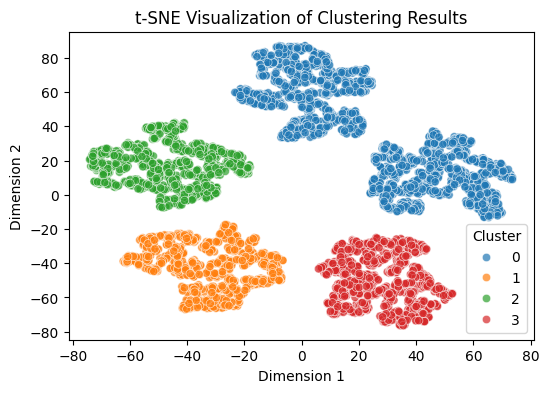

In [14]:
# Plot the t-SNE results
clustering_model.plot_tsne(labels)